In [1]:
#The linear model is considered as the null hypothesis
#Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize, stats
import csv

In [2]:
#Convert the dat file to csv file
# read testdata.dat to a list of lists
datContent = [i.strip().split() for i in open("./testdata.dat").readlines()]

# write it as a new CSV file
with open("./testdata.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(datContent)

In [3]:
#read the csv file
global data, x, y, sigma_y, val1, val2, val3  #defined as global so all functions can access these values
data = pd.read_csv('testdata.csv')
x = data['x']
y = data['y']
sigma_y = data['sigma_y']

#initialise theta for all the fits to zero
val1 = np.array([0, 0])
val2 = np.array([0, 0, 0])
val3 = np.array([0, 0, 0, 0])

In [4]:
#Defining the required functions for fitting
def linearFunc(x, val1):
    return val1[1]*x+val1[0]

def quadraticFunc(x, val2):
    return val2[2]*x**2 + val2[1]*x + val2[0]

def cubicFunc(x, val3):
    return val3[3]*x**3 + val3[2]*x**2 + val3[1]*x + val3[0]

In [5]:
#The log-likelihood function
#The log-likelihood function is maximum for best fitting value of theta
def logL(theta, n):
    if n==1:
        y_fit = linearFunc(x, theta)
    elif n==2:
        y_fit = quadraticFunc(x, theta)
    elif n==3:
        y_fit = cubicFunc(x, theta)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

In [6]:
#This function returns the best theta for the fitting
def best_theta(n, theta_val):
    if n==1:
        theta_0 = (n+1)*[0]
        neg_logL = lambda theta: -logL(theta, 1)
        return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)
    if n==2:
        theta_0 = (n+1)*[0]
        neg_logL = lambda theta: -logL(theta, 2)
        return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)
    if n==3:
        theta_0 = (n+1)*[0]
        neg_logL = lambda theta: -logL(theta, 3)
        return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

In [7]:
#compute chi2 likelihood for frequentist
def compute_chi2(n):
    if n==1:
        theta = best_theta(n, val1)
        resid = ((y - linearFunc(x, theta)) / sigma_y)
    elif n==2:
        theta = best_theta(n, val2)
        resid = ((y - quadraticFunc(x, theta)) / sigma_y)
    elif n==3:
        theta = best_theta(n, val3)
        resid = ((y - cubicFunc(x, theta)) / sigma_y)

    return np.sum(resid ** 2)

def compute_dof(degree, data=data):
    return data.shape[0] - (degree + 1)

def chi2_likelihood(n):
    chi2 = compute_chi2(n)
    dof = compute_dof(n)
    return stats.chi2(dof).pdf(chi2)

In [8]:
#Compute the p value for the fit using linear model as the null hypothesis
def p_val(n):
    return 1-stats.chi2(n-1).cdf(compute_chi2(1) - compute_chi2(n))

In [9]:
#Compute the optimized values of the parameters
r1 = best_theta(1, val1)
r2 = best_theta(2, val2)
r3 = best_theta(3, val3)

In [10]:
print("Log L values")
print("linear model:    logL =", logL(best_theta(1, val1), 1))
print("quadratic model: logL =", logL(best_theta(2, val2), 2))
print("cubic model:    logL =", logL(best_theta(3, val3), 3))

Log L values
linear model:    logL = 22.01834340803627
quadratic model: logL = 22.924910312002723
cubic model:    logL = 23.13040925879735


In [11]:
print("chi2 likelihood")
print("- linear model:    ", chi2_likelihood(1))
print("- quadratic model: ", chi2_likelihood(2))
print("- cubic model: ", chi2_likelihood(3))

chi2 likelihood
- linear model:     0.045383795585920046
- quadratic model:  0.036608447550142253
- cubic model:  0.04215280601014979


In [12]:
print("p_values") #The p value for null hypothesis will not be defined as the delta chi square value is zero
print("- quadratic model: ", p_val(2))
print("- cubic model: ", p_val(3))

p_values
- quadratic model:  0.1781327569531711
- cubic model:  0.32887884419649793


In [13]:
"""
From the p values of frequentist analysis, as both the p values are greater than 0.05, we can not reject our
Null Hypothesis.
"""

'\nFrom the p values of frequentist analysis, as both the p values are greater than 0.05, we can not reject our\nNull Hypothesis.\n'

In [14]:
"""Bayesian Analysis"""
#Compute the AICc values as number of data points is considerably small
AIC1 = -2*logL(r1, 1) + (2.0*2*20)/(17.0)
AIC2 = -2*logL(r2, 2) + (2.0*3*20)/(16.0)
AIC3 = -2*logL(r3, 3) + (2.0*4*20)/(15.0)

#Compute the BIC values
BIC1 = -2*logL(r1, 1) + 2*np.log(x.shape[0])
BIC2 = -2*logL(r2, 2) + 3*np.log(x.shape[0])
BIC3 = -2*logL(r3, 3) + 4*np.log(x.shape[0])

In [15]:
print("AICc values")
print("- linear model:    ", AIC1)
print("- quadratic model: ", AIC2)
print("- cubic model: ", AIC3)

AICc values
- linear model:     -39.330804463131365
- quadratic model:  -38.349820624005446
- cubic model:  -35.594151850928036


In [16]:
#Computing delta AIC
AIC_min = min(AIC1, AIC2, AIC3)
print("Delta AIC values")
print("- linear model:    ", AIC1-AIC_min)
print("- quadratic model: ", AIC2-AIC_min)
print("- cubic model: ", AIC3-AIC_min)

Delta AIC values
- linear model:     0.0
- quadratic model:  0.9809838391259191
- cubic model:  3.7366526122033292


In [17]:
"""
For quadratic model, 0 < delta AIC < 2, which implies that quadratic model also has a substantial support.
For cubic model, 2 < delta AIC < 4, which implies that cubic model has cosiderably less support.
"""

'\nFor quadratic model, 0 < delta AIC < 2, which implies that quadratic model also has a substantial support.\nFor cubic model, 2 < delta AIC < 4, which implies that cubic model has cosiderably less support.\n'

In [18]:
print("BIC vlaues")
print("- linear model:    ", BIC1)
print("- quadratic model: ", BIC2)
print("- cubic model: ", BIC3)

BIC vlaues
- linear model:     -38.04522226896456
- quadratic model:  -36.862623803343475
- cubic model:  -34.27788942337874


In [19]:
#Computing delta BIC
BIC_min = min(BIC1, BIC2, BIC3)
print("Delta BIC values")
print("- linear model:    ", BIC1-BIC_min)
print("- quadratic model: ", BIC2-BIC_min)
print("- cubic model: ", BIC3-BIC_min)

Delta BIC values
- linear model:     0.0
- quadratic model:  1.1825984656210835
- cubic model:  3.7673328455858197


In [20]:
"""
For quadratic model, 0 < delta BIC < 2, which implies that there is no evidence against quadratic model.
For cubic model, 2 < delta AIC < 4, which implies that there is positive evidence against cubic model.
"""

'\nFor quadratic model, 0 < delta BIC < 2, which implies that there is no evidence against quadratic model.\nFor cubic model, 2 < delta AIC < 4, which implies that there is positive evidence against cubic model.\n'

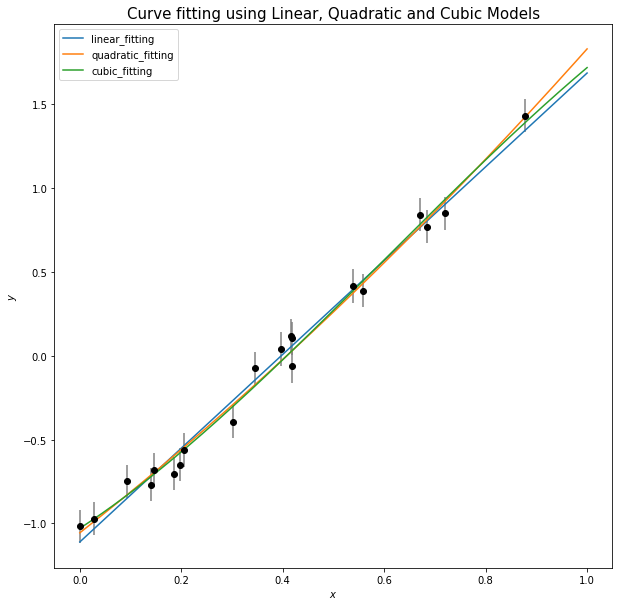

In [21]:
"""Plotting"""
t =  np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(t, linearFunc(t, r1), label='linear_fitting')
plt.plot(t, quadraticFunc(t, r2), label='quadratic_fitting')
plt.plot(t, cubicFunc(t, r3), label='cubic_fitting')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Curve fitting using Linear, Quadratic and Cubic Models", size=15)
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor = 'gray')
plt.show()